#评估线性回归模型

 在这个主题中，我们将介绍回归模型拟合数据的效果。上一个主题我们拟合了数据，但是并没太关注拟合的效果。每当拟合工作做完之后，我们应该问的第一个问题就是“拟合的效果如何？”本主题将回答这个问题。

<!-- TEASER_END -->

##Getting ready

我们还用上一主题里的`lr`对象和`boston`数据集。`lr`对象已经拟合过数据，现在有许多方法可以用。

In [1]:
from sklearn import datasets
boston = datasets.load_boston()
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(boston.data, boston.target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [2]:
predictions = lr.predict(boston.data)

##How to do it...

我们可以看到一些简单的量度（metris）和图形。让我们看看上一章的残差图：

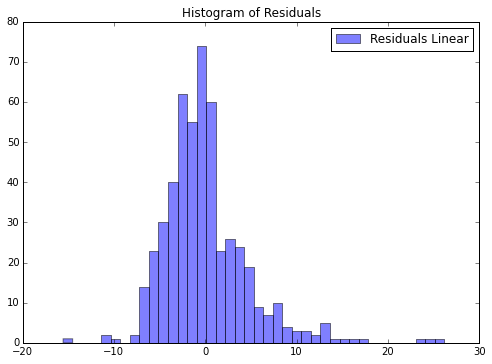

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(boston.target - predictions,bins=40, label='Residuals Linear', color='b', alpha=.5);
ax.set_title("Histogram of Residuals")
ax.legend(loc='best');

如果你用IPython Notebook，就用`%matplotlib inline`命令在网页中显示matplotlib图形。如果你不用，就用`f.savefig('myfig.png')`保存图形，以备使用。

>画图的库是[matplotlib](http://matplotlib.org/)，并非本书重点，但是可视化效果非常好。

和之前介绍的一样，误差项服从均值为0的正态分布。残差就是误差，所以这个图也应噶近似正态分布。看起来拟合挺好的，只是有点偏。我们计算一下残差的均值，应该很接近0：

In [4]:
import numpy as np
np.mean(boston.target - predictions)

6.0382090193051989e-16

另一个值得看的图是**Q-Q图（分位数概率分布）**，我们用Scipy来实现图形，因为它内置这个概率分布图的方法：

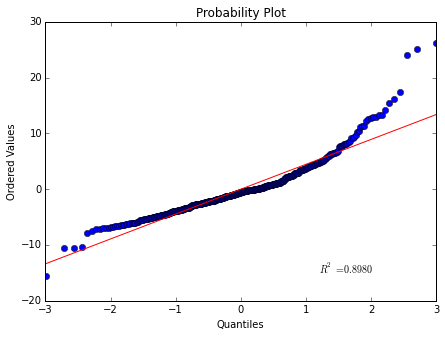

In [5]:
from scipy.stats import probplot
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
probplot(boston.target - predictions, plot=ax);

这个图里面倾斜的数据比之前看的要更清楚一些。

我们还可以观察拟合其他量度，最常用的还有均方误差（mean squared error，MSE），平均绝对误差（mean absolute deviation，MAD）。让我们用Python实现这两个量度。后面我们用scikit-learn内置的量度来评估回归模型的效果：

In [6]:
def MSE(target, predictions):
    squared_deviation = np.power(target - predictions, 2)
    return np.mean(squared_deviation)

In [7]:
MSE(boston.target, predictions)

21.897779217687496

In [8]:
def MAD(target, predictions):
    absolute_deviation = np.abs(target - predictions)
    return np.mean(absolute_deviation)

In [9]:
MAD(boston.target, predictions)

3.2729446379969396

##How it works...

MSE的计算公式是：

$$E(\hat y_t - y_i)^2$$

计算预测值与实际值的差，平方之后再求平均值。这其实就是我们寻找最佳相关系数时是目标。高斯－马尔可夫定理（Gauss-Markov theorem）实际上已经证明了线性回归的回归系数的最佳线性无偏估计（BLUE）就是最小均方误差的无偏估计（条件是误差变量不相关，0均值，同方差）。在**用岭回归弥补线性回归的不足**主题中，我们会看到，当我们的相关系数是有偏估计时会发生什么。

MAD是平均绝对误差，计算公式为：

$$E|\hat y_t - y_i|$$

线性回归的时候MAD通常不用，但是值得一看。为什么呢？可以看到每个量度的情况，还可以判断哪个量度更重要。例如，用MSE，较大的误差会获得更大的惩罚，因为平方把它放大。

###There's more...

还有一点需要说明，那就是相关系数是随机变量，因此它们是有分布的。让我们用bootstrapping（重复试验）来看看犯罪率的相关系数的分布情况。bootstrapping是一种学习参数估计不确定性的常用手段：

In [15]:
n_bootstraps = 1000
len_boston = len(boston.target)
subsample_size = np.int(0.5*len_boston)
subsample = lambda: np.random.choice(np.arange(0, len_boston),size=subsample_size)
coefs = np.ones(n_bootstraps) #相关系数初始值设为1
for i in range(n_bootstraps):
    subsample_idx = subsample()
    subsample_X = boston.data[subsample_idx]
    subsample_y = boston.target[subsample_idx]
    lr.fit(subsample_X, subsample_y)
    coefs[i] = lr.coef_[0]

我们可以看到这个相关系数的分布直方图：

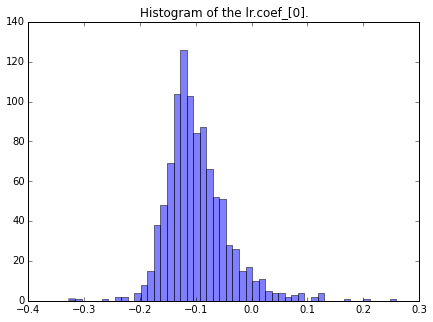

In [18]:
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(111)
ax.hist(coefs, bins=50, color='b', alpha=.5)
ax.set_title("Histogram of the lr.coef_[0].");

我们还想看看重复试验后的置信区间：

In [17]:
np.percentile(coefs, [2.5, 97.5])

array([-0.18030624,  0.03816062])

置信区间的范围表面犯罪率其实不影响房价，因为0在置信区间里面，表面犯罪率可能与房价无关。

值得一提的是，bootstrapping可以获得更好的相关系数估计值，因为使用bootstrapping方法的均值，会比普通估计方法更快地**收敛（converge）**到真实均值。